In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.insert(0,'/content/gdrive/My Drive/EECS545')

In [3]:
import os

# TODO: Fill in the Google Drive path where you uploaded the files 
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = './EECS545/'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['COVID_combined', 'Normal', 'maskHE2_labels.csv', 'test', 'validation', 'ReadMe.gdoc', 'training.ipynb', 'training', 'train_dataset.npy', 'valid_dataset.npy', 'train_dataset_jiahong.npy', 'valid_dataset_jiahong.npy', 'Model_LungSegmentation', 'Model_Without_Lungseg', 'images_nomask', 'HE_output2.zip', 'Things to be done for Final Project.gdoc', 'Siamese_Learning.ipynb', 'grad_labels.csv', 'Matching_code', 'val_labels.csv', 'test_labels.csv', 'train_labels.csv', 'Copy of Siamese_Learning.ipynb', 'COVID-19 X-Ray Image Classification Using Transfer Learning and Contrastive Learning.gslides', 'Training_VGG16_CrossValidation_WithLungMasking.ipynb', 'grad_labels_4.csv', 'grad_labels_new.csv', 'create_label.ipynb']


In [4]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "US/Eastern"
time.tzset()

import numpy as np 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from skimage import io, transform
from PIL import Image

import copy

**Transform dataset- Data Augmentation**

In [ ]:
train_transforms = transforms.Compose([
            transforms.RandomRotation(30),
            transforms.CenterCrop(224),   #I thing CenterCrop makes more sense than randomCrop, because the lung is ususally at the center of the image
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])  #used for data augmentation

val_transforms = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

test_transforms = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

train_csv = os.path.join(GOOGLE_DRIVE_PATH,'train_labels.csv')
val_csv = os.path.join(GOOGLE_DRIVE_PATH,'val_labels.csv')
test_csv = os.path.join(GOOGLE_DRIVE_PATH,'test_labels.csv')

class_numbers = 2

test_path = os.path.join(GOOGLE_DRIVE_PATH,"test")
train_path = os.path.join(GOOGLE_DRIVE_PATH,"training")
val_path = os.path.join(GOOGLE_DRIVE_PATH,"validation")

batch_size = 32

**adding the Kfold**

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [ ]:
train_df1 = pd.read_csv(train_csv)
train_df2 = pd.read_csv(val_csv)
train_df=train_df2.append(train_df1,ignore_index=True,sort=True)
print(train_df)

               Images  encoded_labels  labels
0       COVID-429.png               0   COVID
1     Normal-2703.png               1  NORMAL
2      Normal-610.png               1  NORMAL
3      COVID-3495.png               0   COVID
4      COVID-3614.png               0   COVID
...               ...             ...     ...
6504   COVID-1288.png               0   COVID
6505   Normal-739.png               1  NORMAL
6506  Normal-1274.png               1  NORMAL
6507   COVID-2156.png               0   COVID
6508  Normal-3293.png               1  NORMAL

[6509 rows x 3 columns]


In [ ]:
train_df['Images']

0         COVID-429.png
1       Normal-2703.png
2        Normal-610.png
3        COVID-3495.png
4        COVID-3614.png
             ...       
6504     COVID-1288.png
6505     Normal-739.png
6506    Normal-1274.png
6507     COVID-2156.png
6508    Normal-3293.png
Name: Images, Length: 6509, dtype: object

In [ ]:
train_features=train_df['Images']
train_target=train_df['encoded_labels']
n_splits = 4 # Number of K-fold Splits

splits = list(StratifiedKFold(n_splits=n_splits, shuffle=True).split(train_features, train_target))
splits

[(array([   0,    1,    3, ..., 6505, 6507, 6508]),
  array([   2,    6,    8, ..., 6500, 6503, 6506])),
 (array([   1,    2,    4, ..., 6505, 6506, 6508]),
  array([   0,    3,   10, ..., 6493, 6501, 6507])),
 (array([   0,    1,    2, ..., 6504, 6506, 6507]),
  array([   7,   14,   21, ..., 6498, 6505, 6508])),
 (array([   0,    2,    3, ..., 6506, 6507, 6508]),
  array([   1,    4,    5, ..., 6492, 6502, 6504]))]

**VGG16**

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16 = models.vgg16(pretrained=True)
#print(vgg16.classifier[6].out_features) # 1000 

# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer

features.extend([nn.Linear(num_features, class_numbers)]) # Add our layer with 2 outputs
vgg16.classifier = nn.Sequential(*features) # Replace the model classifier

vgg16 = vgg16.to(device)

print(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

**DataLoader For Test**

In [ ]:
class CovidDataset(Dataset):  # 0 stands for Covid and 1 stands for Normal

  def __init__(self, csv_file, root_dir, transform=None):
    self.XRay_image = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.XRay_image)

  def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.XRay_image.iloc[idx, 0])
        #print(img_name)
        image = io.imread(img_name)  #print(image)     #print(np.max(image))
        image = np.expand_dims(image,axis = 2) #(512,512) but the input of VGG should have three channels
        image = np.repeat(image, 3, axis=2) #(512, 512, 3)
        #print(type(image))   #print(image.shape)

        image = Image.fromarray(image, 'RGB') # change to PIL image inorder to use transformation
        #plt.figure()
        #plt.imshow(image)
        label = int(self.XRay_image.iloc[idx, 2])
        print(label)
        #lable = label.astype('float')
        #print(label)

        if self.transform:
            image = self.transform(image)

        sample = (image, label)
        return sample


In [ ]:
test_transforms = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
test_dataset = CovidDataset(csv_file=test_csv, root_dir=test_path, transform=test_transforms)
test_loader=torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

**Dataloader Function For Cross validation-Training**

In [ ]:
class CovidDataset_Train(Dataset):  # 0 stands for Covid and 1 stands for Normal

  def __init__(self, pandas_file,root_dir1, root_dir,transform=None):
    self.XRay_image = pandas_file
    self.root_dir = root_dir
    self.root_dir1 = root_dir1
    self.transform = transform

  def __len__(self):
    return len(self.XRay_image)

  def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name1 = os.path.join(self.root_dir, self.XRay_image.iloc[idx,0])
        img_name2 = os.path.join(self.root_dir1, self.XRay_image.iloc[idx,0])
        if os.path.exists(img_name1):
          true_name=img_name1
        else:
          true_name=img_name2

        #print(img_name)
        image = io.imread(true_name)  #print(image)     #print(np.max(image))
        image = np.expand_dims(image,axis = 2) #(512,512) but the input of VGG should have three channels
        image = np.repeat(image, 3, axis=2) #(512, 512, 3)
        #print(type(image))   #print(image.shape)

        image = Image.fromarray(image, 'RGB') # change to PIL image inorder to use transformation
        #plt.figure()
        #plt.imshow(image)
        label = int(self.XRay_image.iloc[idx, 1])
        #lable = label.astype('float')
        #print(label)

        if self.transform:
            image = self.transform(image)

        sample = (image, label)
        return sample

In [ ]:
train_transforms = transforms.Compose([
            transforms.RandomRotation(30),
            transforms.CenterCrop(224),   #I thing CenterCrop makes more sense than randomCrop, because the lung is ususally at the center of the image
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])  #used for data augmentation

val_transforms = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])


In [ ]:
train_df

,Images,encoded_labels,labels
0,COVID-429.png,0,COVID
1,Normal-2703.png,1,NORMAL
2,Normal-610.png,1,NORMAL
3,COVID-3495.png,0,COVID
4,COVID-3614.png,0,COVID
...,...,...,...
6504,COVID-1288.png,0,COVID
6505,Normal-739.png,1,NORMAL
6506,Normal-1274.png,1,NORMAL
6507,COVID-2156.png,0,COVID


**Training With Cross Validation**

In [ ]:
num_epochs = 30 # it will multiple with 5 bc of cross validation
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.002, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [ ]:
since = time.time()
model=vgg16
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

train_acc_history  = []
val_acc_history = []
train_loss_history = []
avg_losses_f = []
avg_val_losses_f = []
for i, (train_idx, valid_idx) in enumerate(splits): 

  print('K-Fold {}/{}'.format(i, n_splits - 1))
  print('-' * 10)  
  Label=train_df['encoded_labels'][train_idx.astype(int)].to_numpy()
  pandas_file=train_df['Images'][train_idx.astype(int)].to_numpy()
  Train_Final_pd=pd.DataFrame({'x':pandas_file,'y':Label})
  Train_loader=CovidDataset_Train(pandas_file=Train_Final_pd,root_dir1=train_path,root_dir=val_path,transform=train_transforms)
  Label_Valid=train_df['encoded_labels'][valid_idx.astype(int)].to_numpy()
  pandas_file_Valid=train_df['Images'][valid_idx.astype(int)].to_numpy()
  Valid_Final_pd=pd.DataFrame({'x':pandas_file_Valid,'y':Label_Valid})
  Valid_loader=CovidDataset_Train(pandas_file=Valid_Final_pd,root_dir1=train_path,root_dir=val_path,transform=train_transforms)
  dataloaders ={"train":torch.utils.data.DataLoader(Train_loader, batch_size=batch_size,shuffle=True), 
             "val":torch.utils.data.DataLoader(Valid_loader, batch_size=batch_size, shuffle=True) }
  dataset_sizes = {"train":len(Train_loader), "val": len(Valid_loader)}

  for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        for phase in ['train', 'val']:
          if phase == 'train':
                model.train()  # Set model to training mode
          else:
                model.eval()
          running_loss = 0.0
          running_corrects = 0
          idx = 0
          for inputs, labels in dataloaders[phase]:
                idx = idx + 1
                inputs = inputs.to(device)
                labels = labels.to(device)
                #print("processing data: ", idx)

                # zero the parameter gradients
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += float(loss.item() * inputs.size(0))
                running_corrects += torch.sum(preds == labels.data)
          if phase == 'train':
                scheduler.step()

          epoch_loss = float(running_loss / dataset_sizes[phase])
          epoch_acc = float(running_corrects.double() / dataset_sizes[phase])
          print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
          if phase=="train":

              train_acc_history.append(epoch_acc)
              train_loss_history.append(epoch_loss)
          if phase =='val':
              val_acc_history.append(epoch_acc)
              if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
  time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
  model.load_state_dict(best_model_wts)






K-Fold 0/3
----------
Epoch 0/29
----------
train Loss: 0.4452 Acc: 0.7906
val Loss: 0.3496 Acc: 0.8501

Epoch 1/29
----------
train Loss: 0.3539 Acc: 0.8394
val Loss: 0.3121 Acc: 0.8643

Epoch 2/29
----------
train Loss: 0.3304 Acc: 0.8566
val Loss: 0.3711 Acc: 0.8292

Epoch 3/29
----------
train Loss: 0.2934 Acc: 0.8730
val Loss: 0.2763 Acc: 0.8808

Epoch 4/29
----------
train Loss: 0.2796 Acc: 0.8760
val Loss: 0.2427 Acc: 0.8980

Epoch 5/29
----------
train Loss: 0.2671 Acc: 0.8820
val Loss: 0.2300 Acc: 0.9122

Epoch 6/29
----------
train Loss: 0.2429 Acc: 0.8957
val Loss: 0.3152 Acc: 0.8643

Epoch 7/29
----------
train Loss: 0.1903 Acc: 0.9178
val Loss: 0.2201 Acc: 0.9128

Epoch 8/29
----------
train Loss: 0.1738 Acc: 0.9285
val Loss: 0.2105 Acc: 0.9115

Epoch 9/29
----------
train Loss: 0.1690 Acc: 0.9308
val Loss: 0.2033 Acc: 0.9214

Epoch 10/29
----------
train Loss: 0.1655 Acc: 0.9344
val Loss: 0.1945 Acc: 0.9214

Epoch 11/29
----------
train Loss: 0.1610 Acc: 0.9373
val Loss: 

In [ ]:

#Don't forget to download the Weights
torch.save(vgg16.state_dict(), 'VGG16_Cross_Validation.pt')
from google.colab import files
files.download('VGG16_Cross_Validation.pt') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Visulization_Result**

ValueError: ignored

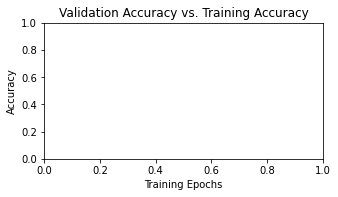

In [ ]:
plt.figure(figsize=(5,2.5)) 
plt.title("Validation Accuracy vs. Training Accuracy")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1,num_epochs+1),val_acc_history,label="validation")
plt.plot(range(1,num_epochs+1),train_acc_history,label="train")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 10))
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(5,2.5)) 
plt.title("Training Loss")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(range(1,num_epochs+1),train_loss_history,label="train")
plt.ylim((0,0.8))
plt.xticks(np.arange(1, num_epochs+1, 10))
plt.legend()
plt.show()